In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import spearmanr, kendalltau
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

In [2]:
l90_train = pd.read_csv("train_data_l90d_daily_balance.csv").sort_values(by=['user_id', 'pt_date'])
n180_train = pd.read_csv("train_data_n180d_daily_balance.csv").sort_values(by=['user_id', 'pt_date'])
train = pd.concat([l90_train, n180_train], ignore_index=True).drop_duplicates().sort_values(by=['user_id', 'pt_date'])

In [3]:
n180_train

,pt_date,user_id,total_balance
8162117,2023-03-01,0000102c03057f91c90faa1011e59870f2f8710597c27b...,76336.380
5806411,2023-03-02,0000102c03057f91c90faa1011e59870f2f8710597c27b...,56345.250
9046517,2023-03-03,0000102c03057f91c90faa1011e59870f2f8710597c27b...,56351.430
1681949,2023-03-04,0000102c03057f91c90faa1011e59870f2f8710597c27b...,56357.610
4334268,2023-03-05,0000102c03057f91c90faa1011e59870f2f8710597c27b...,54586.290
...,...,...,...
5044775,2023-08-24,ffff10e7cfb57aec0f3f16b43446b0ca83df037706f662...,0.735
4161653,2023-08-25,ffff10e7cfb57aec0f3f16b43446b0ca83df037706f662...,0.735
4455745,2023-08-26,ffff10e7cfb57aec0f3f16b43446b0ca83df037706f662...,150.735
5044771,2023-08-27,ffff10e7cfb57aec0f3f16b43446b0ca83df037706f662...,78.750


In [4]:
# Create a new DataFrame to store the calculated deposits
df = n180_train.copy()

# Calculate the deposit for each user
df['daily_balance_change'] = df.groupby('user_id')['total_balance'].diff().fillna(0)

# Now, merge the calculated deposits back into the original DataFrame
n180_train = n180_train.merge(df[['user_id', 'pt_date', 'daily_balance_change']], on=['user_id', 'pt_date'], how='left')

In [5]:
n180_train

,pt_date,user_id,total_balance,daily_balance_change
0,2023-03-01,0000102c03057f91c90faa1011e59870f2f8710597c27b...,76336.380,0.000
1,2023-03-02,0000102c03057f91c90faa1011e59870f2f8710597c27b...,56345.250,-19991.130
2,2023-03-03,0000102c03057f91c90faa1011e59870f2f8710597c27b...,56351.430,6.180
3,2023-03-04,0000102c03057f91c90faa1011e59870f2f8710597c27b...,56357.610,6.180
4,2023-03-05,0000102c03057f91c90faa1011e59870f2f8710597c27b...,54586.290,-1771.320
...,...,...,...,...
9132169,2023-08-24,ffff10e7cfb57aec0f3f16b43446b0ca83df037706f662...,0.735,0.000
9132170,2023-08-25,ffff10e7cfb57aec0f3f16b43446b0ca83df037706f662...,0.735,0.000
9132171,2023-08-26,ffff10e7cfb57aec0f3f16b43446b0ca83df037706f662...,150.735,150.000
9132172,2023-08-27,ffff10e7cfb57aec0f3f16b43446b0ca83df037706f662...,78.750,-71.985


In [6]:
# Use kendall coefficient (association between date and user's total balance) to quantify trend
# positive coefficient + stat. significant p-value = user has positive trend

kendall_coeff = n180_train.groupby('user_id').apply(
    lambda group: kendalltau(group['pt_date'], group['total_balance'])[0]).reset_index()

kendall_coeff.columns = ['user_id', 'kendall_coeff']

kendall_p = n180_train.groupby('user_id').apply(
    lambda group: kendalltau(group['pt_date'], group['total_balance'])[1]).reset_index()

kendall_p.columns = ['user_id', 'kendall_p']

kendall = kendall_coeff.merge(kendall_p, on='user_id')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


In [7]:
result = n180_train.groupby('user_id').agg(total_balance_std=('total_balance', 'std'),
                                     total_balance_mean=('total_balance', 'mean'),
                                    ).reset_index()

result['coefficient_of_variation'] = result['total_balance_std'] / result['total_balance_mean']

result['coefficient_of_variation_scaled'] = (result['coefficient_of_variation'] - min(result['coefficient_of_variation'])) / \
(max(result['coefficient_of_variation']) - min(result['coefficient_of_variation']))

result['indiv_stability'] = 1 - result['coefficient_of_variation_scaled']

result['weight'] = result['total_balance_mean'] / result['total_balance_mean'].sum()

result['weighted_stability'] = result['weight'] * result['indiv_stability']

In [8]:
result

,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability
0,0000102c03057f91c90faa1011e59870f2f8710597c27b...,45243.699703,41095.061436,1.100952,0.081795,0.918205,5.624714e-06,5.164639e-06
1,0001c00642af4db4bfab49d3884b5e88f72acddc4cb03b...,3161.852939,3349.629282,0.943941,0.070124,0.929876,4.584664e-07,4.263168e-07
2,0003c76e33adfa3484f6f8426d6f840cdaaade5bf71a2a...,5271.281887,11782.886271,0.447368,0.033213,0.966787,1.612733e-06,1.559170e-06
3,0003e52fe559c035a21c6b38b6f16612a6689ea555480e...,3926.671208,2615.796464,1.501138,0.111542,0.888458,3.580261e-07,3.180912e-07
4,0004d0051f38ca5c9df27bca501d556fd16fa9acd2df39...,22558.703492,25889.839972,0.871334,0.064727,0.935273,3.543563e-06,3.314198e-06
...,...,...,...,...,...,...,...,...
50449,fff76a8dfb3e78fe545169ce8427012d783ab7f51e9fe1...,6365.608460,4673.157597,1.362164,0.101212,0.898788,6.396188e-07,5.748818e-07
50450,fff798878bc2bb60ead2b2c405bc1c4bdc1b1ff713a422...,47920.641286,33262.260249,1.440691,0.107049,0.892951,4.552632e-06,4.065278e-06
50451,fff7d14c2d27b7ba9c8c2e06940d38d17566b7ae04f208...,14628.913557,63009.921630,0.232168,0.017216,0.982784,8.624218e-06,8.475740e-06
50452,fffae87c8a91a689bac61b5451f1f9887e681ccd723013...,141732.310104,241833.926685,0.586073,0.043523,0.956477,3.310000e-05,3.165939e-05


In [9]:
result.weight.sum()

1.0

In [10]:
# join with kendall data
result = result.merge(kendall, on='user_id')
result['stat_sig'] = np.where(result['kendall_p'] < 0.01, 1, 0)

In [11]:
result

,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig
0,0000102c03057f91c90faa1011e59870f2f8710597c27b...,45243.699703,41095.061436,1.100952,0.081795,0.918205,5.624714e-06,5.164639e-06,-0.300264,2.003198e-09,1
1,0001c00642af4db4bfab49d3884b5e88f72acddc4cb03b...,3161.852939,3349.629282,0.943941,0.070124,0.929876,4.584664e-07,4.263168e-07,-0.482259,5.475184e-22,1
2,0003c76e33adfa3484f6f8426d6f840cdaaade5bf71a2a...,5271.281887,11782.886271,0.447368,0.033213,0.966787,1.612733e-06,1.559170e-06,0.776059,2.916951e-54,1
3,0003e52fe559c035a21c6b38b6f16612a6689ea555480e...,3926.671208,2615.796464,1.501138,0.111542,0.888458,3.580261e-07,3.180912e-07,-0.076611,1.268563e-01,0
4,0004d0051f38ca5c9df27bca501d556fd16fa9acd2df39...,22558.703492,25889.839972,0.871334,0.064727,0.935273,3.543563e-06,3.314198e-06,0.411418,1.984180e-16,1
...,...,...,...,...,...,...,...,...,...,...,...
50449,fff76a8dfb3e78fe545169ce8427012d783ab7f51e9fe1...,6365.608460,4673.157597,1.362164,0.101212,0.898788,6.396188e-07,5.748818e-07,0.174626,4.861282e-04,1
50450,fff798878bc2bb60ead2b2c405bc1c4bdc1b1ff713a422...,47920.641286,33262.260249,1.440691,0.107049,0.892951,4.552632e-06,4.065278e-06,0.127440,1.086058e-02,0
50451,fff7d14c2d27b7ba9c8c2e06940d38d17566b7ae04f208...,14628.913557,63009.921630,0.232168,0.017216,0.982784,8.624218e-06,8.475740e-06,0.097238,5.195669e-02,0
50452,fffae87c8a91a689bac61b5451f1f9887e681ccd723013...,141732.310104,241833.926685,0.586073,0.043523,0.956477,3.310000e-05,3.165939e-05,0.686433,7.729889e-43,1


In [12]:
result.describe()

,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig
count,5.045400e+04,5.045400e+04,50454.000000,50454.000000,50454.000000,5.045400e+04,5.045400e+04,50454.000000,5.045400e+04,50454.000000
mean,4.692139e+04,1.448083e+05,0.859019,0.063812,0.936188,1.982003e-05,1.934347e-05,0.102710,6.850144e-02,0.788243
std,3.447124e+05,5.105547e+05,0.967120,0.071888,0.071888,6.988003e-05,6.789436e-05,0.513223,1.911093e-01,0.408558
min,1.225385e+00,1.681575e+00,0.000554,0.000000,0.000000,2.301585e-10,0.000000e+00,-0.980936,0.000000e+00,0.000000
25%,4.076628e+03,6.014208e+03,0.209871,0.015559,0.910851,8.231694e-07,7.434501e-07,-0.287583,1.330599e-35,1.000000
50%,1.587365e+04,3.369462e+04,0.622734,0.046248,0.953752,4.611809e-06,4.329185e-06,0.013633,5.752171e-12,1.000000
75%,4.803001e+04,1.559519e+05,1.199886,0.089149,0.984441,2.134526e-05,2.089954e-05,0.460282,1.956036e-03,1.000000
max,6.953506e+07,4.792924e+07,13.453624,1.000000,1.000000,6.560113e-03,6.543465e-03,1.000000,1.000000e+00,1.000000


### Growth Subset

In [13]:
# function to check for monotonic increase
def has_monotonic_increase(series):
    return (series >= 0).all()

# Filter users with a monotonic increase
monotonic_increase_users = n180_train.groupby('user_id')['daily_balance_change'].agg(has_monotonic_increase).reset_index()
monotonic_increase_users = monotonic_increase_users[monotonic_increase_users['daily_balance_change']]

# List of user_ids with monotonic increase
monotonic_increase_user_ids = monotonic_increase_users['user_id'].tolist()
print(len(monotonic_increase_user_ids))

5561


In [14]:
n180_train_mi = n180_train[n180_train['user_id'].isin(monotonic_increase_user_ids)]

In [15]:
n180_train_mi

,pt_date,user_id,total_balance,daily_balance_change
3439,2023-03-01,001a715b939bf433a617647d07260598c4325f993c9568...,566735.130,0.000
3440,2023-03-02,001a715b939bf433a617647d07260598c4325f993c9568...,576097.245,9362.115
3441,2023-03-03,001a715b939bf433a617647d07260598c4325f993c9568...,576160.380,63.135
3442,2023-03-04,001a715b939bf433a617647d07260598c4325f993c9568...,576223.530,63.150
3443,2023-03-05,001a715b939bf433a617647d07260598c4325f993c9568...,576286.680,63.150
...,...,...,...,...
9131264,2023-08-24,fff48bdb32290abf723aacd38aad6b55652d83c711d779...,710.220,0.060
9131265,2023-08-25,fff48bdb32290abf723aacd38aad6b55652d83c711d779...,710.295,0.075
9131266,2023-08-26,fff48bdb32290abf723aacd38aad6b55652d83c711d779...,710.370,0.075
9131267,2023-08-27,fff48bdb32290abf723aacd38aad6b55652d83c711d779...,710.445,0.075


In [16]:
result_mi = result[result['user_id'].isin(monotonic_increase_user_ids)]
result_mi

,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig
19,001a715b939bf433a617647d07260598c4325f993c9568...,30866.798384,632080.061934,0.048834,0.003589,0.996411,8.651330e-05,8.620283e-05,1.0,0.0,1
36,0035690b444a0b283827827cd7794c0fa743dd616e35dd...,1.702700,348.273398,0.004889,0.000322,0.999678,4.766846e-08,4.765310e-08,1.0,0.0,1
43,003c234e6b3dbb40765f14e4d241de0de736e9f7fb5b33...,3.651753,628.623978,0.005809,0.000391,0.999609,8.604026e-08,8.600666e-08,1.0,0.0,1
50,0042ecce6cf8baa73ccfb2dad48f0a73787df4375736c8...,20035.047492,141190.150359,0.141901,0.010507,0.989493,1.932481e-05,1.912177e-05,1.0,0.0,1
52,0045899e3e970428b69f953eaa1a35f5439ac6df83493a...,594.306637,1842.240663,0.322600,0.023938,0.976062,2.521489e-07,2.461129e-07,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
50397,ffc4dfe57b652875c8f6d438ca862c7408548d29af3e98...,93.134474,16476.918398,0.005652,0.000379,0.999621,2.255209e-06,2.254354e-06,1.0,0.0,1
50408,ffcdb3f2e9a759a27be62a0f509a0b475a969667b7a02f...,176.174396,31207.430552,0.005645,0.000378,0.999622,4.271386e-06,4.269769e-06,1.0,0.0,1
50430,ffddac4dab8a974da3bb7097a90856e64663a6575bbc83...,2.396328,449.116492,0.005336,0.000355,0.999645,6.147093e-08,6.144908e-08,1.0,0.0,1
50439,ffec15acbdc51db656f32b3da5b7695f9f7e7f4604b0ba...,688.904755,979.045028,0.703650,0.052263,0.947737,1.340027e-07,1.269993e-07,1.0,0.0,1


In [17]:
user_balances = n180_train_mi.groupby('user_id')['total_balance']
initial_balance = user_balances.first()
final_balance = user_balances.last()

# Calculate the balance growth rate for each user
balance_growth_rate = (final_balance - initial_balance) / initial_balance

# Create a new DataFrame to store user_id and their respective growth rates
growth_rate_df = pd.DataFrame({'user_id': balance_growth_rate.index, 'balance_growth_rate': balance_growth_rate.values})

# Display the resulting DataFrame
growth_rate_df

,user_id,balance_growth_rate
0,001a715b939bf433a617647d07260598c4325f993c9568...,0.180281
1,0035690b444a0b283827827cd7794c0fa743dd616e35dd...,0.017253
2,003c234e6b3dbb40765f14e4d241de0de736e9f7fb5b33...,0.019910
3,0042ecce6cf8baa73ccfb2dad48f0a73787df4375736c8...,0.445247
4,0045899e3e970428b69f953eaa1a35f5439ac6df83493a...,0.993426
...,...,...
5556,ffc4dfe57b652875c8f6d438ca862c7408548d29af3e98...,0.019432
5557,ffcdb3f2e9a759a27be62a0f509a0b475a969667b7a02f...,0.019398
5558,ffddac4dab8a974da3bb7097a90856e64663a6575bbc83...,0.018581
5559,ffec15acbdc51db656f32b3da5b7695f9f7e7f4604b0ba...,3.206251


In [18]:
result_mi = result_mi.merge(growth_rate_df, on='user_id')
result_mi

,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,balance_growth_rate
0,001a715b939bf433a617647d07260598c4325f993c9568...,30866.798384,632080.061934,0.048834,0.003589,0.996411,8.651330e-05,8.620283e-05,1.0,0.0,1,0.180281
1,0035690b444a0b283827827cd7794c0fa743dd616e35dd...,1.702700,348.273398,0.004889,0.000322,0.999678,4.766846e-08,4.765310e-08,1.0,0.0,1,0.017253
2,003c234e6b3dbb40765f14e4d241de0de736e9f7fb5b33...,3.651753,628.623978,0.005809,0.000391,0.999609,8.604026e-08,8.600666e-08,1.0,0.0,1,0.019910
3,0042ecce6cf8baa73ccfb2dad48f0a73787df4375736c8...,20035.047492,141190.150359,0.141901,0.010507,0.989493,1.932481e-05,1.912177e-05,1.0,0.0,1,0.445247
4,0045899e3e970428b69f953eaa1a35f5439ac6df83493a...,594.306637,1842.240663,0.322600,0.023938,0.976062,2.521489e-07,2.461129e-07,1.0,0.0,1,0.993426
...,...,...,...,...,...,...,...,...,...,...,...,...
5556,ffc4dfe57b652875c8f6d438ca862c7408548d29af3e98...,93.134474,16476.918398,0.005652,0.000379,0.999621,2.255209e-06,2.254354e-06,1.0,0.0,1,0.019432
5557,ffcdb3f2e9a759a27be62a0f509a0b475a969667b7a02f...,176.174396,31207.430552,0.005645,0.000378,0.999622,4.271386e-06,4.269769e-06,1.0,0.0,1,0.019398
5558,ffddac4dab8a974da3bb7097a90856e64663a6575bbc83...,2.396328,449.116492,0.005336,0.000355,0.999645,6.147093e-08,6.144908e-08,1.0,0.0,1,0.018581
5559,ffec15acbdc51db656f32b3da5b7695f9f7e7f4604b0ba...,688.904755,979.045028,0.703650,0.052263,0.947737,1.340027e-07,1.269993e-07,1.0,0.0,1,3.206251


In [19]:
result_mi = result_mi.sort_values(by=['balance_growth_rate'], ascending=False)
result_mi['cumulative_weight'] = result_mi['weight'].cumsum()

result_mi

,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,balance_growth_rate,cumulative_weight
3628,a60426d6f7c0971052fe88dd76c9ab9381d558d5c05f70...,171334.336653,1.114223e+05,1.537702,0.114260,0.885740,0.000015,0.000014,1.0,0.0,1,927.713289,0.000015
4590,d31a8c4b8d8a228b1f4640e658b57470cbadc9b504cc5e...,117348.293847,2.075533e+05,0.565389,0.041986,0.958014,0.000028,0.000027,1.0,0.0,1,848.857997,0.000044
1160,359d4a5ee72cd98362fb77af16aad2d1d048c19ad8cba8...,133416.856552,7.312364e+05,0.182454,0.013521,0.986479,0.000100,0.000099,1.0,0.0,1,811.643460,0.000144
793,24e9e3ff7b0f35ec2a0f6645d76f516be93ae161928359...,107782.188954,9.718389e+04,1.109054,0.082398,0.917602,0.000013,0.000012,1.0,0.0,1,676.781629,0.000157
4608,d3fe1b55174f74f6eb40cd7d3193a9bb3068f8538e8397...,139081.246574,3.182237e+05,0.437055,0.032446,0.967554,0.000044,0.000042,1.0,0.0,1,535.368275,0.000201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,20d5bd9888a9059faf9a3383989468b626b3fefcdc9e45...,18604.170455,5.156032e+06,0.003608,0.000227,0.999773,0.000706,0.000706,1.0,0.0,1,0.012495,0.117263
5076,ea83f79d44ae18d294db23ccfe033728dfb0f9ceffe62b...,22016.761626,6.146636e+06,0.003582,0.000225,0.999775,0.000841,0.000841,1.0,0.0,1,0.012400,0.118105
3757,ab2bb1c1146ec6804436a8e2a3a376dd55a43966e6cb21...,27112.510267,7.625817e+06,0.003555,0.000223,0.999777,0.001044,0.001044,1.0,0.0,1,0.012304,0.119149
4402,c9945cb16cdb26287b24e07cd095d775a61c15cae7b9f2...,54113.127301,1.546431e+07,0.003499,0.000219,0.999781,0.002117,0.002116,1.0,0.0,1,0.012101,0.121265


In [20]:
result_mi.describe()

,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,balance_growth_rate,cumulative_weight
count,5.561000e+03,5.561000e+03,5561.000000,5561.000000,5561.000000,5.561000e+03,5.561000e+03,5561.0,5561.0,5561.0,5561.000000,5561.000000
mean,7.801324e+03,1.623611e+05,0.076030,0.005610,0.994390,2.222250e-05,2.214405e-05,1.0,0.0,1.0,1.712743,0.046812
std,2.752500e+04,4.826077e+05,0.197432,0.014676,0.014676,6.605490e-05,6.597206e-05,0.0,0.0,0.0,25.147128,0.024480
min,1.580597e+00,3.028742e+02,0.003495,0.000219,0.715496,4.145463e-08,4.144025e-08,1.0,0.0,1.0,0.012085,0.000015
25%,9.540784e+00,1.559915e+03,0.005609,0.000376,0.996767,2.135068e-07,2.134273e-07,1.0,0.0,1.0,0.019306,0.030952
50%,3.511245e+02,2.018032e+04,0.005650,0.000379,0.999621,2.762096e-06,2.715660e-06,1.0,0.0,1.0,0.019418,0.047813
75%,3.497942e+03,1.563050e+05,0.044054,0.003233,0.999624,2.139358e-05,2.135278e-05,1.0,0.0,1.0,0.153814,0.066222
max,1.135185e+06,1.690793e+07,3.828008,0.284504,0.999781,2.314202e-03,2.313696e-03,1.0,0.0,1.0,927.713289,0.123579


Obtain growth subset portfolio

In [21]:
growth_subset_ptf = result_mi[result_mi['cumulative_weight'] <= 0.05]
growth_subset_ptf

,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,balance_growth_rate,cumulative_weight
3628,a60426d6f7c0971052fe88dd76c9ab9381d558d5c05f70...,171334.336653,111422.336022,1.537702,0.114260,0.885740,0.000015,0.000014,1.0,0.0,1,927.713289,0.000015
4590,d31a8c4b8d8a228b1f4640e658b57470cbadc9b504cc5e...,117348.293847,207553.349171,0.565389,0.041986,0.958014,0.000028,0.000027,1.0,0.0,1,848.857997,0.000044
1160,359d4a5ee72cd98362fb77af16aad2d1d048c19ad8cba8...,133416.856552,731236.397320,0.182454,0.013521,0.986479,0.000100,0.000099,1.0,0.0,1,811.643460,0.000144
793,24e9e3ff7b0f35ec2a0f6645d76f516be93ae161928359...,107782.188954,97183.886436,1.109054,0.082398,0.917602,0.000013,0.000012,1.0,0.0,1,676.781629,0.000157
4608,d3fe1b55174f74f6eb40cd7d3193a9bb3068f8538e8397...,139081.246574,318223.720939,0.437055,0.032446,0.967554,0.000044,0.000042,1.0,0.0,1,535.368275,0.000201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,2de04c29a7309adf4246bf25ac1eeaee9e0f2a7c8f1b65...,173.513841,30721.054558,0.005648,0.000379,0.999621,0.000004,0.000004,1.0,0.0,1,0.019408,0.049947
3417,9cca21bf680da48c30bf73964a758ca2c4c27985ac166f...,519.678602,92015.703729,0.005648,0.000379,0.999621,0.000013,0.000013,1.0,0.0,1,0.019408,0.049960
1768,51219439ae5b73193c349ed5d9344636dade0cbac46e14...,218.143263,38627.568481,0.005647,0.000379,0.999621,0.000005,0.000005,1.0,0.0,1,0.019408,0.049965
4768,db33b1c14167391191502534d86756feb27414aa3250cf...,591.840436,104792.508812,0.005648,0.000379,0.999621,0.000014,0.000014,1.0,0.0,1,0.019408,0.049980


In [22]:
growth_subset_ptf.describe()

,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,balance_growth_rate,cumulative_weight
count,3.172000e+03,3.172000e+03,3172.000000,3172.000000,3172.000000,3.172000e+03,3.172000e+03,3172.0,3172.0,3172.0,3172.000000,3172.000000
mean,1.288830e+04,1.151543e+05,0.129254,0.009567,0.990433,1.576126e-05,1.563079e-05,1.0,0.0,1.0,2.988737,0.030660
std,3.555012e+04,3.035403e+05,0.248495,0.018471,0.018471,4.154580e-05,4.132844e-05,0.0,0.0,0.0,33.241755,0.018448
min,2.755815e+00,3.158521e+02,0.005086,0.000337,0.715496,4.323093e-08,4.284121e-08,1.0,0.0,1.0,0.019408,0.000015
25%,4.391397e+01,2.461953e+03,0.005681,0.000381,0.988557,3.369695e-07,3.346257e-07,1.0,0.0,1.0,0.019529,0.010986
50%,5.275537e+02,1.997549e+04,0.021680,0.001570,0.998430,2.734062e-06,2.667558e-06,1.0,0.0,1.0,0.074814,0.040322
75%,1.106923e+04,1.113189e+05,0.154497,0.011443,0.999619,1.523631e-05,1.487792e-05,1.0,0.0,1.0,0.593330,0.047220
max,1.135185e+06,5.612995e+06,3.828008,0.284504,0.999663,7.682551e-04,7.650896e-04,1.0,0.0,1.0,927.713289,0.049995


In [23]:
growth_subset_ptf['subset_weight'] = growth_subset_ptf['total_balance_mean'] / growth_subset_ptf['total_balance_mean'].sum()
print(growth_subset_ptf['subset_weight'].sum())

1.0


/var/folders/_q/069x_2nn7mbcxxk8h2s825640000gn/T/ipykernel_11213/1143258189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth_subset_ptf['subset_weight'] = growth_subset_ptf['total_balance_mean'] / growth_subset_ptf['total_balance_mean'].sum()


In [24]:
growth_subset_ptf['subset_weighted_stability'] = growth_subset_ptf['subset_weight'] * growth_subset_ptf['indiv_stability']
growth_subset_ptf

/var/folders/_q/069x_2nn7mbcxxk8h2s825640000gn/T/ipykernel_11213/1562155650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth_subset_ptf['subset_weighted_stability'] = growth_subset_ptf['subset_weight'] * growth_subset_ptf['indiv_stability']


,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,balance_growth_rate,cumulative_weight,subset_weight,subset_weighted_stability
3628,a60426d6f7c0971052fe88dd76c9ab9381d558d5c05f70...,171334.336653,111422.336022,1.537702,0.114260,0.885740,0.000015,0.000014,1.0,0.0,1,927.713289,0.000015,0.000305,0.000270
4590,d31a8c4b8d8a228b1f4640e658b57470cbadc9b504cc5e...,117348.293847,207553.349171,0.565389,0.041986,0.958014,0.000028,0.000027,1.0,0.0,1,848.857997,0.000044,0.000568,0.000544
1160,359d4a5ee72cd98362fb77af16aad2d1d048c19ad8cba8...,133416.856552,731236.397320,0.182454,0.013521,0.986479,0.000100,0.000099,1.0,0.0,1,811.643460,0.000144,0.002002,0.001975
793,24e9e3ff7b0f35ec2a0f6645d76f516be93ae161928359...,107782.188954,97183.886436,1.109054,0.082398,0.917602,0.000013,0.000012,1.0,0.0,1,676.781629,0.000157,0.000266,0.000244
4608,d3fe1b55174f74f6eb40cd7d3193a9bb3068f8538e8397...,139081.246574,318223.720939,0.437055,0.032446,0.967554,0.000044,0.000042,1.0,0.0,1,535.368275,0.000201,0.000871,0.000843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,2de04c29a7309adf4246bf25ac1eeaee9e0f2a7c8f1b65...,173.513841,30721.054558,0.005648,0.000379,0.999621,0.000004,0.000004,1.0,0.0,1,0.019408,0.049947,0.000084,0.000084
3417,9cca21bf680da48c30bf73964a758ca2c4c27985ac166f...,519.678602,92015.703729,0.005648,0.000379,0.999621,0.000013,0.000013,1.0,0.0,1,0.019408,0.049960,0.000252,0.000252
1768,51219439ae5b73193c349ed5d9344636dade0cbac46e14...,218.143263,38627.568481,0.005647,0.000379,0.999621,0.000005,0.000005,1.0,0.0,1,0.019408,0.049965,0.000106,0.000106
4768,db33b1c14167391191502534d86756feb27414aa3250cf...,591.840436,104792.508812,0.005648,0.000379,0.999621,0.000014,0.000014,1.0,0.0,1,0.019408,0.049980,0.000287,0.000287


In [25]:
growth_subset_ptf.describe()

,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,balance_growth_rate,cumulative_weight,subset_weight,subset_weighted_stability
count,3.172000e+03,3.172000e+03,3172.000000,3172.000000,3172.000000,3.172000e+03,3.172000e+03,3172.0,3172.0,3172.0,3172.000000,3172.000000,3.172000e+03,3.172000e+03
mean,1.288830e+04,1.151543e+05,0.129254,0.009567,0.990433,1.576126e-05,1.563079e-05,1.0,0.0,1.0,2.988737,0.030660,3.152585e-04,3.126487e-04
std,3.555012e+04,3.035403e+05,0.248495,0.018471,0.018471,4.154580e-05,4.132844e-05,0.0,0.0,0.0,33.241755,0.018448,8.310036e-04,8.266559e-04
min,2.755815e+00,3.158521e+02,0.005086,0.000337,0.715496,4.323093e-08,4.284121e-08,1.0,0.0,1.0,0.019408,0.000015,8.647098e-07,8.569145e-07
25%,4.391397e+01,2.461953e+03,0.005681,0.000381,0.988557,3.369695e-07,3.346257e-07,1.0,0.0,1.0,0.019529,0.010986,6.740100e-06,6.693220e-06
50%,5.275537e+02,1.997549e+04,0.021680,0.001570,0.998430,2.734062e-06,2.667558e-06,1.0,0.0,1.0,0.074814,0.040322,5.468701e-05,5.335680e-05
75%,1.106923e+04,1.113189e+05,0.154497,0.011443,0.999619,1.523631e-05,1.487792e-05,1.0,0.0,1.0,0.593330,0.047220,3.047584e-04,2.975898e-04
max,1.135185e+06,5.612995e+06,3.828008,0.284504,0.999663,7.682551e-04,7.650896e-04,1.0,0.0,1.0,927.713289,0.049995,1.536672e-02,1.530341e-02


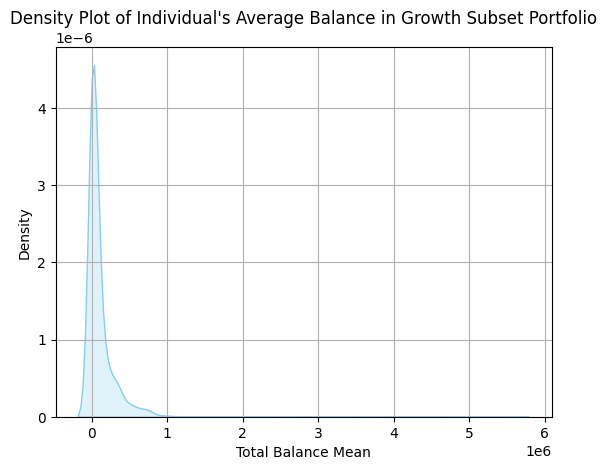

In [26]:
sns.kdeplot(data=growth_subset_ptf, x='total_balance_mean', fill=True, color='skyblue')

plt.xlabel('Total Balance Mean')
plt.ylabel('Density')
plt.title("Density Plot of Individual's Average Balance in Growth Subset Portfolio")
plt.grid(True)
plt.show()

In [27]:
growth_subset_ptf_users = growth_subset_ptf.user_id.unique().tolist()

In [28]:
growth_subset_ptf_total_bal_by_date = n180_train[n180_train['user_id'].isin(growth_subset_ptf_users)]\
.groupby('pt_date')['total_balance'].sum().reset_index()

growth_subset_ptf_total_bal_by_date

,pt_date,total_balance
0,2023-03-01,3.025369e+08
1,2023-03-02,3.034104e+08
2,2023-03-03,3.046294e+08
3,2023-03-04,3.055235e+08
4,2023-03-05,3.057649e+08
...,...,...
176,2023-08-24,4.212183e+08
177,2023-08-25,4.222659e+08
178,2023-08-26,4.227928e+08
179,2023-08-27,4.233528e+08


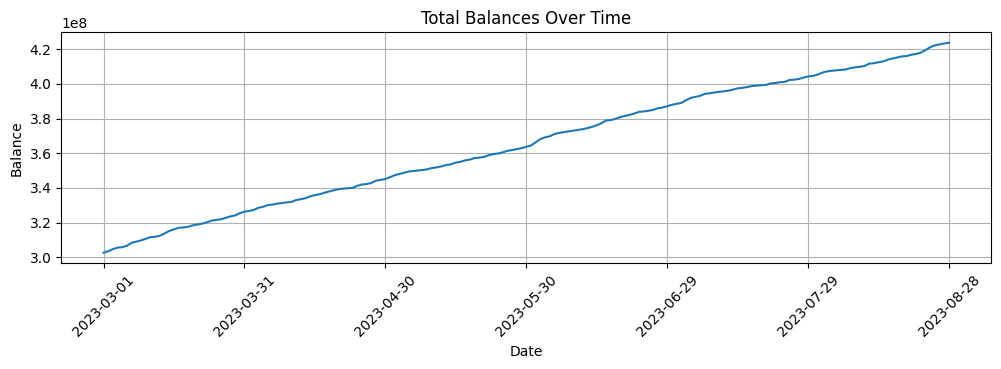

In [29]:
plt.figure(figsize=(12, 3))

# Plot the lines for each column
plt.plot(growth_subset_ptf_total_bal_by_date['pt_date'], growth_subset_ptf_total_bal_by_date['total_balance'])

# Set labels for the axes and the legend
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Total Balances Over Time')
plt.xticks(np.arange(0, len(growth_subset_ptf_total_bal_by_date['pt_date']), 30), rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.grid(True)
plt.show()

In [30]:
final = growth_subset_ptf_total_bal_by_date.iloc[-1,1]
initial = growth_subset_ptf_total_bal_by_date.iloc[0,1]

growth_subset_ptf_growth_rate = (final - initial) / initial

print("Growth Subset Portfolio Growth Rate: " + str(growth_subset_ptf_growth_rate))

Growth Subset Portfolio Growth Rate: 0.4006761448692721


In [31]:
print("Growth Subset Portfolio Stability: " + str(growth_subset_ptf['subset_weighted_stability'].sum()))

Growth Subset Portfolio Stability: 0.991721758917806


In [32]:
ptf_total_bal_by_date = n180_train.groupby('pt_date')['total_balance'].sum().reset_index()
ptf_total_bal_by_date

,pt_date,total_balance
0,2023-03-01,8.888307e+09
1,2023-03-02,8.836282e+09
2,2023-03-03,8.819826e+09
3,2023-03-04,8.774141e+09
4,2023-03-05,8.723953e+09
...,...,...
176,2023-08-24,6.313775e+09
177,2023-08-25,6.318009e+09
178,2023-08-26,6.304411e+09
179,2023-08-27,6.287521e+09


In [33]:
final_ptf_bal = ptf_total_bal_by_date.iloc[-1,1]
initial_ptf_bal = ptf_total_bal_by_date.iloc[0,1]

ptf_growth_rate = (final_ptf_bal - initial_ptf_bal) / initial_ptf_bal
print("Overall Portfolio Growth Rate: " + str(ptf_growth_rate))

Overall Portfolio Growth Rate: -0.297008901927312


In [34]:
print("Overall Portfolio Stability: " + str(result['weighted_stability'].sum()))

Overall Portfolio Stability: 0.9759556867683834


### Stable Subset

In [35]:
result_ssp = result.sort_values(by=['indiv_stability'], ascending=False)
result_ssp

,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig
17238,5748773986747cf385a0369fe5235cf04a0a7bd1d1ea2c...,8.317242,15007.478122,0.000554,0.000000,1.000000e+00,2.054085e-06,2.054085e-06,0.053739,0.283004,0
34580,af076ef3ee35cae775ac92ca96f55ff26b4678aef7d309...,174.649890,300213.603398,0.000582,0.000002,9.999980e-01,4.109047e-05,4.109039e-05,-0.106757,0.033631,0
8049,2875ba8d3ebd2afb3d34c021205df99bf38611ef2a6cb4...,54.796510,75036.326354,0.000730,0.000013,9.999869e-01,1.027028e-05,1.027015e-05,0.176645,0.000448,1
15312,4def93b39a528206a4b6dba40d3480d0be33b9a40b7286...,590.276551,751008.114448,0.000786,0.000017,9.999828e-01,1.027911e-04,1.027893e-04,0.111602,0.025708,0
4262,156ad1c5e6553ae2506c4564409d7d3113634860dfa537...,590.416749,750990.123729,0.000786,0.000017,9.999828e-01,1.027886e-04,1.027868e-04,0.052688,0.293007,0
...,...,...,...,...,...,...,...,...,...,...,...
4720,17b7c0456a843f0da24d6e8d357046c60ee04c44ede4f4...,55906.043782,4155.463508,13.453624,1.000000,2.220446e-16,5.687616e-07,1.262904e-22,-0.105118,0.084978,0
24234,7a482b532b2feeee3c44970e2d5134e4612db2fef112c3...,29.751091,2.211381,13.453624,1.000000,1.110223e-16,3.026735e-10,3.360351e-26,-0.105118,0.084978,0
14222,483f4f74ea2b4a6ada14b0b3f3f3ede60573dcbdc9f81e...,1260.962841,93.726630,13.453624,1.000000,1.110223e-16,1.282844e-08,1.424243e-24,-0.105118,0.084978,0
43688,dd43c3fade0a1c0457d7a8bbc0253eb235c87053af9862...,713.110829,53.005110,13.453624,1.000000,0.000000e+00,7.254852e-09,0.000000e+00,-0.105118,0.084978,0


In [36]:
result_ssp_filtered = result_ssp[(result_ssp['kendall_coeff'] > 0) & (result_ssp['stat_sig'] == 1)]
result_ssp_filtered

,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig
8049,2875ba8d3ebd2afb3d34c021205df99bf38611ef2a6cb4...,54.796510,75036.326354,0.000730,0.000013,0.999987,1.027028e-05,1.027015e-05,0.176645,4.475255e-04,1
12024,3cca1ff89a429c43c91dbdde7ac0f15f835f73a3195759...,129.991344,150195.397956,0.000865,0.000023,0.999977,2.055736e-05,2.055689e-05,0.159853,1.398387e-03,1
11753,3b73ee45fe01d592030679cef9cddc5178852fff5611d5...,402.395459,450496.999558,0.000893,0.000025,0.999975,6.165988e-05,6.165833e-05,0.264462,1.395041e-07,1
7916,27e4e2f287582e037deb9bc59bb6efdeafc0f259b9105e...,755.148007,751711.099475,0.001005,0.000033,0.999967,1.028873e-04,1.028839e-04,0.188214,1.686708e-04,1
49245,f9d82adf2b438186214db3e72962448d3a0b90547b1ee2...,776.765858,750023.214282,0.001036,0.000036,0.999964,1.026563e-04,1.026526e-04,0.555310,1.268403e-28,1
...,...,...,...,...,...,...,...,...,...,...,...
31220,9e0e064c823896aa23e9c7dc32384b5ff44f5c0171aa29...,5600.211820,483.742956,11.576834,0.860494,0.139506,6.621028e-08,9.236763e-09,0.900085,4.597262e-68,1
39876,c959a7aee448b429268a5be8acafd12bc247c96bbb8461...,440.809988,37.323315,11.810580,0.877868,0.122132,5.108472e-09,6.239056e-10,0.911057,3.736348e-66,1
36401,b822ab56a5e5251be8946671af2b4ffdc333e37687d747...,500.184605,41.732983,11.985355,0.890860,0.109140,5.712027e-09,6.234112e-10,0.372359,3.567253e-12,1
8652,2bb1b0df0eccbd20674584ebfec32985c4a53172bb9a40...,95.124165,7.930773,11.994311,0.891526,0.108474,1.085491e-09,1.177480e-10,0.648375,1.684848e-26,1


In [37]:
result_ssp_filtered['cumulative_weight'] = result_ssp_filtered['weight'].cumsum()
result_ssp_filtered

/var/folders/_q/069x_2nn7mbcxxk8h2s825640000gn/T/ipykernel_11213/1306316173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_ssp_filtered['cumulative_weight'] = result_ssp_filtered['weight'].cumsum()


,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,cumulative_weight
8049,2875ba8d3ebd2afb3d34c021205df99bf38611ef2a6cb4...,54.796510,75036.326354,0.000730,0.000013,0.999987,1.027028e-05,1.027015e-05,0.176645,4.475255e-04,1,0.000010
12024,3cca1ff89a429c43c91dbdde7ac0f15f835f73a3195759...,129.991344,150195.397956,0.000865,0.000023,0.999977,2.055736e-05,2.055689e-05,0.159853,1.398387e-03,1,0.000031
11753,3b73ee45fe01d592030679cef9cddc5178852fff5611d5...,402.395459,450496.999558,0.000893,0.000025,0.999975,6.165988e-05,6.165833e-05,0.264462,1.395041e-07,1,0.000092
7916,27e4e2f287582e037deb9bc59bb6efdeafc0f259b9105e...,755.148007,751711.099475,0.001005,0.000033,0.999967,1.028873e-04,1.028839e-04,0.188214,1.686708e-04,1,0.000195
49245,f9d82adf2b438186214db3e72962448d3a0b90547b1ee2...,776.765858,750023.214282,0.001036,0.000036,0.999964,1.026563e-04,1.026526e-04,0.555310,1.268403e-28,1,0.000298
...,...,...,...,...,...,...,...,...,...,...,...,...
31220,9e0e064c823896aa23e9c7dc32384b5ff44f5c0171aa29...,5600.211820,483.742956,11.576834,0.860494,0.139506,6.621028e-08,9.236763e-09,0.900085,4.597262e-68,1,0.488908
39876,c959a7aee448b429268a5be8acafd12bc247c96bbb8461...,440.809988,37.323315,11.810580,0.877868,0.122132,5.108472e-09,6.239056e-10,0.911057,3.736348e-66,1,0.488908
36401,b822ab56a5e5251be8946671af2b4ffdc333e37687d747...,500.184605,41.732983,11.985355,0.890860,0.109140,5.712027e-09,6.234112e-10,0.372359,3.567253e-12,1,0.488908
8652,2bb1b0df0eccbd20674584ebfec32985c4a53172bb9a40...,95.124165,7.930773,11.994311,0.891526,0.108474,1.085491e-09,1.177480e-10,0.648375,1.684848e-26,1,0.488908


In [38]:
stable_subset_ptf = result_ssp_filtered[result_ssp_filtered['cumulative_weight'] <= 0.05]

In [39]:
stable_subset_ptf['subset_weight'] = stable_subset_ptf['total_balance_mean'] / stable_subset_ptf['total_balance_mean'].sum()
print(growth_subset_ptf['subset_weight'].sum())

1.0


/var/folders/_q/069x_2nn7mbcxxk8h2s825640000gn/T/ipykernel_11213/744632069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stable_subset_ptf['subset_weight'] = stable_subset_ptf['total_balance_mean'] / stable_subset_ptf['total_balance_mean'].sum()


In [40]:
stable_subset_ptf['subset_weighted_stability'] = stable_subset_ptf['subset_weight'] * stable_subset_ptf['indiv_stability']
stable_subset_ptf

/var/folders/_q/069x_2nn7mbcxxk8h2s825640000gn/T/ipykernel_11213/1136820293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stable_subset_ptf['subset_weighted_stability'] = stable_subset_ptf['subset_weight'] * stable_subset_ptf['indiv_stability']


,user_id,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,cumulative_weight,subset_weight,subset_weighted_stability
8049,2875ba8d3ebd2afb3d34c021205df99bf38611ef2a6cb4...,54.796510,75036.326354,0.000730,0.000013,0.999987,0.000010,0.000010,0.176645,4.475255e-04,1,0.000010,0.000206,0.000206
12024,3cca1ff89a429c43c91dbdde7ac0f15f835f73a3195759...,129.991344,150195.397956,0.000865,0.000023,0.999977,0.000021,0.000021,0.159853,1.398387e-03,1,0.000031,0.000412,0.000412
11753,3b73ee45fe01d592030679cef9cddc5178852fff5611d5...,402.395459,450496.999558,0.000893,0.000025,0.999975,0.000062,0.000062,0.264462,1.395041e-07,1,0.000092,0.001234,0.001234
7916,27e4e2f287582e037deb9bc59bb6efdeafc0f259b9105e...,755.148007,751711.099475,0.001005,0.000033,0.999967,0.000103,0.000103,0.188214,1.686708e-04,1,0.000195,0.002060,0.002060
49245,f9d82adf2b438186214db3e72962448d3a0b90547b1ee2...,776.765858,750023.214282,0.001036,0.000036,0.999964,0.000103,0.000103,0.555310,1.268403e-28,1,0.000298,0.002055,0.002055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47440,f0587ef3bab9166442f7699f2b99105286c32b42bf7383...,3514.273333,775684.935497,0.004531,0.000296,0.999704,0.000106,0.000106,1.000000,0.000000e+00,1,0.049523,0.002126,0.002125
33301,a8a87c1acf6c0420ba9691d146eda1fe87bf1fd6221b85...,3514.065569,775626.854088,0.004531,0.000296,0.999704,0.000106,0.000106,1.000000,0.000000e+00,1,0.049629,0.002125,0.002125
25105,7eaa66e56c1defbd0aaec4c43af72265834900e35ab010...,3513.732542,775530.852348,0.004531,0.000296,0.999704,0.000106,0.000106,1.000000,0.000000e+00,1,0.049735,0.002125,0.002125
2058,0a4cbaaaa801f72cc0b0060dfe7d3e499ce06252795bb7...,3513.651369,775505.077790,0.004531,0.000296,0.999704,0.000106,0.000106,1.000000,0.000000e+00,1,0.049842,0.002125,0.002124


In [41]:
stable_subset_ptf.describe()

,total_balance_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability,kendall_coeff,kendall_p,stat_sig,cumulative_weight,subset_weight,subset_weighted_stability
count,382.000000,3.820000e+02,382.000000,382.000000,382.000000,3.820000e+02,3.820000e+02,382.000000,3.820000e+02,382.0,382.000000,382.000000,382.000000
mean,3497.434702,9.553031e+05,0.003666,0.000231,0.999769,1.307531e-04,1.307229e-04,0.795398,4.398327e-05,1.0,0.026531,0.002618,0.002617
std,5226.043516,1.529663e+06,0.000894,0.000066,0.000066,2.093662e-04,2.093229e-04,0.261544,4.949721e-04,0.0,0.015780,0.004192,0.004191
min,2.762524,7.607476e+02,0.000730,0.000013,0.999704,1.041241e-07,1.041003e-07,0.130878,0.000000e+00,1.0,0.000010,0.000002,0.000002
25%,903.787377,3.070612e+05,0.003158,0.000194,0.999716,4.202771e-05,4.201778e-05,0.632658,0.000000e+00,1.0,0.009219,0.000841,0.000841
50%,2849.450325,7.660420e+05,0.003970,0.000254,0.999746,1.048488e-04,1.048270e-04,0.931062,2.707716e-77,1.0,0.029866,0.002099,0.002099
75%,3755.324393,8.575420e+05,0.004374,0.000284,0.999806,1.173725e-04,1.173457e-04,1.000000,1.199356e-36,1.0,0.040377,0.002350,0.002349
max,59089.271931,1.690793e+07,0.004531,0.000296,0.999987,2.314202e-03,2.313696e-03,1.000000,8.900244e-03,1.0,0.049948,0.046333,0.046322


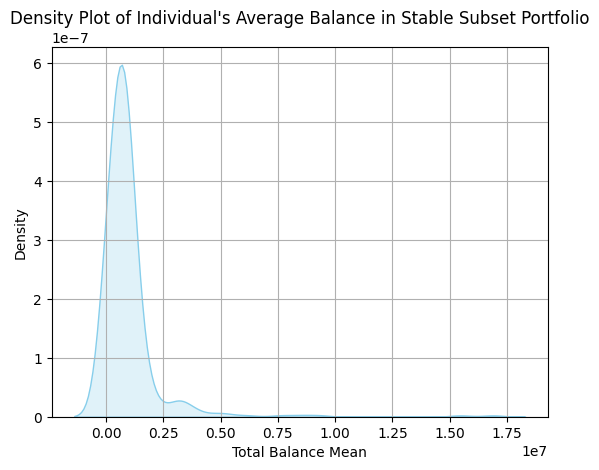

In [42]:
sns.kdeplot(data=stable_subset_ptf, x='total_balance_mean', fill=True, color='skyblue')

plt.xlabel('Total Balance Mean')
plt.ylabel('Density')
plt.title("Density Plot of Individual's Average Balance in Stable Subset Portfolio")
plt.grid(True)
plt.show()

In [43]:
stable_subset_ptf_users = stable_subset_ptf.user_id.unique().tolist()

In [44]:
stable_subset_ptf_total_bal_by_date = n180_train[n180_train['user_id'].isin(stable_subset_ptf_users)]\
.groupby('pt_date')['total_balance'].sum().reset_index()

stable_subset_ptf_total_bal_by_date

,pt_date,total_balance
0,2023-03-01,3.627396e+08
1,2023-03-02,3.627763e+08
2,2023-03-03,3.627851e+08
3,2023-03-04,3.628160e+08
4,2023-03-05,3.628460e+08
...,...,...
176,2023-08-24,3.669340e+08
177,2023-08-25,3.669619e+08
178,2023-08-26,3.669859e+08
179,2023-08-27,3.670130e+08


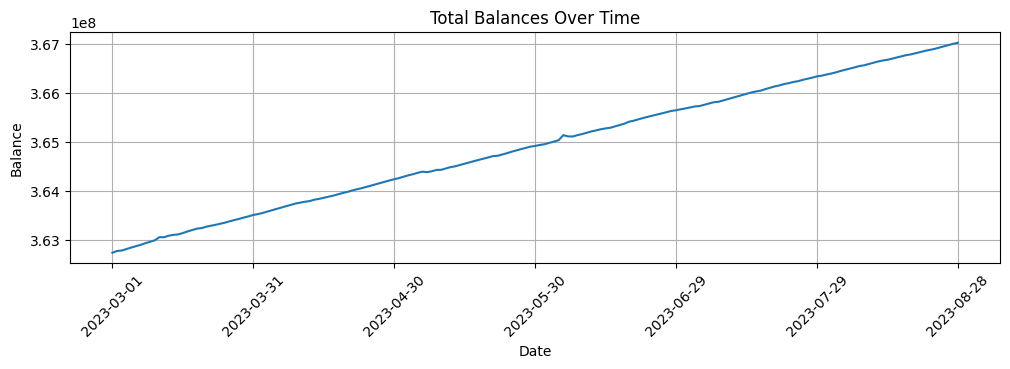

In [45]:
plt.figure(figsize=(12, 3))

# Plot the lines for each column
plt.plot(stable_subset_ptf_total_bal_by_date['pt_date'], stable_subset_ptf_total_bal_by_date['total_balance'])

# Set labels for the axes and the legend
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Total Balances Over Time')
plt.xticks(np.arange(0, len(stable_subset_ptf_total_bal_by_date['pt_date']), 30), rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.grid(True)
plt.show()

In [46]:
final = stable_subset_ptf_total_bal_by_date.iloc[-1,1]
initial = stable_subset_ptf_total_bal_by_date.iloc[0,1]

stable_subset_ptf_growth_rate = (final - initial) / initial

print("Stable Subset Portfolio Growth Rate: " + str(stable_subset_ptf_growth_rate))

Stable Subset Portfolio Growth Rate: 0.011839927337702522


In [47]:
print("Stable Subset Portfolio Stability: " + str(stable_subset_ptf['subset_weighted_stability'].sum()))

Stable Subset Portfolio Stability: 0.9997690588998418


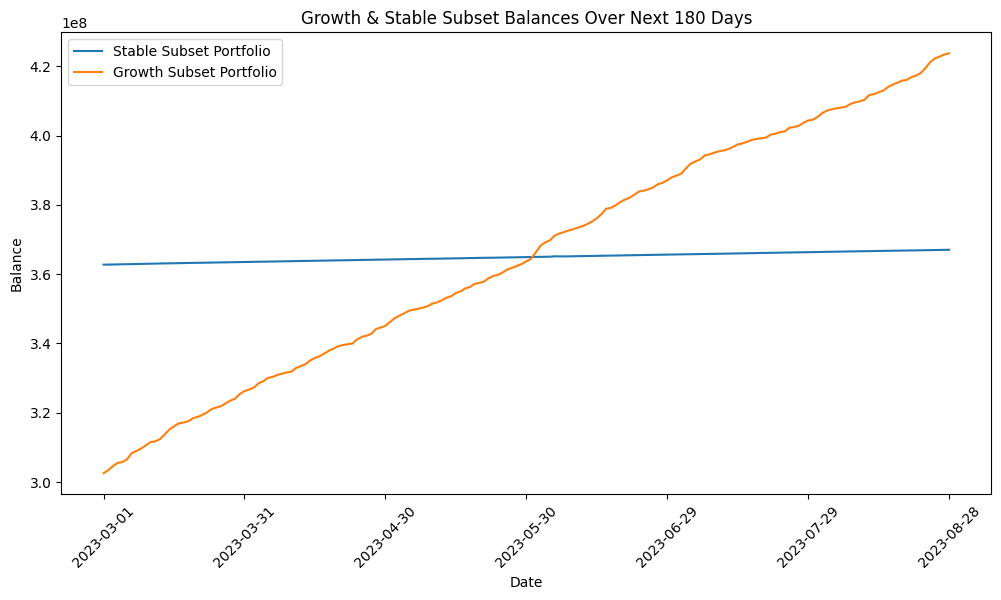

In [48]:
plt.figure(figsize=(12, 6))

# Plot the lines for each column
plt.plot(stable_subset_ptf_total_bal_by_date['pt_date'], stable_subset_ptf_total_bal_by_date['total_balance'], label='Stable Subset Portfolio')
plt.plot(growth_subset_ptf_total_bal_by_date['pt_date'], growth_subset_ptf_total_bal_by_date['total_balance'], label='Growth Subset Portfolio')

# Set labels for the axes and the legend
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Growth & Stable Subset Balances Over Next 180 Days')
plt.xticks(np.arange(0, len(stable_subset_ptf_total_bal_by_date['pt_date']), 30), rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

# Show the plot
# plt.grid(True)
plt.show()

### Creating labels

In [49]:
# Create lists of unique user IDs
all_users = df.user_id.unique().tolist()
growth_subset_ptf_users = growth_subset_ptf.user_id.unique().tolist()
stable_subset_ptf_users = stable_subset_ptf.user_id.unique().tolist()

# Create a DataFrame with user IDs
result_df = pd.DataFrame({'user_id': all_users})

# Create binary columns for 'is_in_stable_subset' and 'is_in_growth_subset'
result_df['is_in_stable_subset'] = result_df['user_id'].isin(stable_subset_ptf_users).astype(int)
result_df['is_in_growth_subset'] = result_df['user_id'].isin(growth_subset_ptf_users).astype(int)

# Concatenate 'is_in_stable_subset' and 'is_in_growth_subset' to create 'label'
result_df['stable_growth_label'] = result_df['is_in_stable_subset'].astype(str) + result_df['is_in_growth_subset'].astype(str)

result_df['text_label'] = np.where(result_df['stable_growth_label'] == '00', 'Neither',
                             np.where(result_df['stable_growth_label'] == '10', 'Stable',
                                     np.where(result_df['stable_growth_label'] == '01', 'Growth', 'Both')))

# Convert 'label' column to integers
result_df['label'] = np.where(result_df['stable_growth_label'] == '00', 0,
                             np.where(result_df['stable_growth_label'] == '10', 1,
                                     np.where(result_df['stable_growth_label'] == '01', 2, 3)))

# Display the resulting DataFrame
result_df

,user_id,is_in_stable_subset,is_in_growth_subset,stable_growth_label,text_label,label
0,0000102c03057f91c90faa1011e59870f2f8710597c27b...,0,0,00,Neither,0
1,0001c00642af4db4bfab49d3884b5e88f72acddc4cb03b...,0,0,00,Neither,0
2,0003c76e33adfa3484f6f8426d6f840cdaaade5bf71a2a...,0,0,00,Neither,0
3,0003e52fe559c035a21c6b38b6f16612a6689ea555480e...,0,0,00,Neither,0
4,0004d0051f38ca5c9df27bca501d556fd16fa9acd2df39...,0,0,00,Neither,0
...,...,...,...,...,...,...
50449,fff76a8dfb3e78fe545169ce8427012d783ab7f51e9fe1...,0,0,00,Neither,0
50450,fff798878bc2bb60ead2b2c405bc1c4bdc1b1ff713a422...,0,0,00,Neither,0
50451,fff7d14c2d27b7ba9c8c2e06940d38d17566b7ae04f208...,0,0,00,Neither,0
50452,fffae87c8a91a689bac61b5451f1f9887e681ccd723013...,0,0,00,Neither,0


In [50]:
result_df.stable_growth_label.value_counts()

00    46900
01     3172
10      382
Name: stable_growth_label, dtype: int64

In [51]:
# result_df.drop(columns='stable_growth_label').to_csv('user_subset_label_v2.csv', index=False)

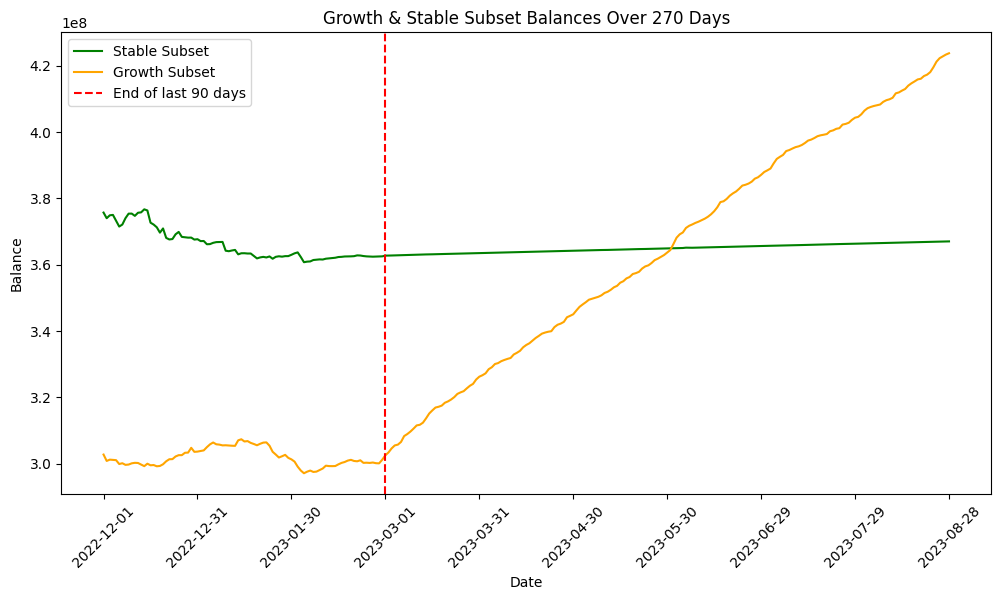

In [52]:
l90_train_stable = train[train['user_id'].isin(stable_subset_ptf_users)].groupby('pt_date')['total_balance'].sum().reset_index()
l90_train_growth = train[train['user_id'].isin(growth_subset_ptf_users)].groupby('pt_date')['total_balance'].sum().reset_index()

plt.figure(figsize=(12, 6))

# Plot the lines for each column
plt.plot(l90_train_stable['pt_date'], l90_train_stable['total_balance'], label='Stable Subset', color='g')
plt.plot(l90_train_growth['pt_date'], l90_train_growth['total_balance'], label='Growth Subset', color='orange')
# plt.plot(l90_train_neither['pt_date'], l90_train_neither['total_balance'], label='Neither Subset Portfolio L90')

# Set labels for the axes and the legend
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Growth & Stable Subset Balances Over 270 Days')
plt.xticks(np.arange(0, len(l90_train_stable['pt_date']), 30), rotation=45)
plt.axvline(x='2023-03-01', color='r', linestyle='--', label='End of last 90 days')
plt.legend()

# Show the plot
plt.show()